In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

from utils.metrics import find_rank, find_quantile_index, compute_cdf
from utils.plot_config import set_matplotlib_config, blend_legend_color_with_alpha

set_matplotlib_config()
SAVE_DIR = Path('../figures/')

In [2]:
exp = xr.open_zarr(
    '/net/argon/landclim/kraftb/machflow_engression/runs_expectiles/default/xval/fold_000/preds.zarr/'
).isel(time=slice(365, None)).sel(time=slice('2017', '2022'))
exp = exp.where((exp.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod']].compute()

eng = xr.open_zarr(
    '/net/argon/landclim/kraftb/machflow_engression/runs_timesplit/combined.zarr/'
).sel(beta=0.67, esl=5, nl=100).sel(time=slice('2017', '2022'))
eng = eng.where((eng.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod']].compute()

pred_eng = eng.Qmm_mod
obs_eng = eng.Qmm

pred_exp = exp.Qmm_mod
obs_exp = exp.Qmm

In [3]:
ranks = xr.apply_ufunc(
    find_rank,
    obs_exp.compute(),                  # Observations with ["time"]
    pred_exp.compute(),                 # Expectile predictions with ["member", "time"]
    input_core_dims=[[], ['member']],   # Observations have no "member" dim, members do
    output_core_dims=[[]],              # Output is scalar per observation
    vectorize=True,                     # Apply function element-wise
    dask='parallelized',                # Enable Dask parallelization if needed
    output_dtypes=[np.float32],         # Output type
)
ranks = ranks.where(ranks!=-1, np.nan)
expectile_indices = ranks - 1
expectiles = pred_exp.member.values[1:-1]

cdf = xr.apply_ufunc(
    compute_cdf,
    expectile_indices,            # Observations with ["time"]
    input_core_dims=[['time']],   # Observations have no "quantile", quantiles do
    output_core_dims=[['time']],  # Output is scalar per observation
    exclude_dims={'time'},
    vectorize=True,               # Apply function element-wise
    dask="parallelized",          # Enable Dask parallelization if needed
    output_dtypes=[np.float32],   # Output type
    kwargs={'num_quantiles': len(expectiles)}
)
cdf = cdf.rename({'time': 'quantile'})
cdf['quantile'] = expectiles
cdf = xr.Dataset({'cdf': cdf})

cdf['rss'] = ((cdf['cdf'] - cdf['quantile']) ** 2).sum(dim='quantile')
cdf['nse'] = 1 - ((obs_exp - pred_exp.median('member')) ** 2).sum('time') / ((obs_exp - obs_exp.mean('time')) ** 2).sum('time')

cdf_df = cdf['cdf'].to_dataframe(name='CDF').reset_index()
rss_df = cdf['rss'].to_dataframe(name='RSS').reset_index()

NSE = 1 - ((obs_exp - pred_exp.sel(member=0.5)) ** 2).sum('time') / ((obs_eng - obs_eng.mean('time')) ** 2).sum('time')
nse_df = NSE.to_dataframe(name='NSE').reset_index()
metric_df = pd.merge(rss_df, nse_df)

metric_df.rename(columns={'beta': 'Beta', 'esl': 'ESL', 'nl': 'NL'}, inplace=True)
cdf_df.rename(columns={'beta': 'Beta', 'esl': 'ESL', 'nl': 'NL', 'quantile': 'Quantile'}, inplace=True)

cdf_exp = cdf
metric_exp_df = metric_df
cdf_exp_df = cdf_df

In [4]:
quantiles = np.arange(start=0.01, stop=1.0, step=0.01)
quantile_values = pred_eng.quantile(quantiles, dim='member', skipna=False)

quantile_indices = xr.apply_ufunc(
    find_quantile_index,
    obs_eng,                            # Observations with ["time"]
    quantile_values,                    # Quantiles with ["quantile", "time"]
    input_core_dims=[[], ['quantile']], # Observations have no "quantile", quantiles do
    output_core_dims=[[]],              # Output is scalar per observation
    vectorize=True,                     # Apply function element-wise
    dask='parallelized',                # Enable Dask parallelization if needed
    output_dtypes=[np.int16],           # Output type
)

cdf = xr.apply_ufunc(
    compute_cdf,
    quantile_indices,                   # Observations with ["time"]
    input_core_dims=[['time']],               # Observations have no "quantile", quantiles do
    output_core_dims=[['time']],              # Output is scalar per observation
    exclude_dims={'time'},
    vectorize=True,                     # Apply function element-wise
    dask="parallelized",                # Enable Dask parallelization if needed
    output_dtypes=[np.float32],           # Output type
    kwargs={'num_quantiles': len(expectiles)}
)
cdf = cdf.rename({'time': 'quantile'})
cdf['quantile'] = np.arange(0.01, 1, 0.01)
cdf = xr.Dataset({'cdf': cdf})

cdf['rss'] = ((cdf['cdf'] - cdf['quantile']) ** 2).sum(dim='quantile')
cdf['nse'] = 1 - ((obs_eng - pred_eng.median('member')) ** 2).sum('time') / ((obs_eng - obs_eng.mean('time')) ** 2).sum('time')
cdf_df = cdf['cdf'].to_dataframe(name='CDF').reset_index()
rss_df = cdf['rss'].to_dataframe(name='RSS').reset_index()

NSE = 1 - ((obs_eng - pred_eng.median('member')) ** 2).sum('time') / ((obs_eng - obs_eng.mean('time')) ** 2).sum('time')
nse_df = NSE.to_dataframe(name='NSE').reset_index()
metric_df = pd.merge(rss_df, nse_df)

metric_df.rename(columns={'beta': 'Beta', 'esl': 'ESL', 'nl': 'NL'}, inplace=True)
cdf_df.rename(columns={'beta': 'Beta', 'esl': 'ESL', 'nl': 'NL', 'quantile': 'Quantile'}, inplace=True)

cdf_eng = cdf
metric_eng_df = metric_df
cdf_eng_df = cdf_df

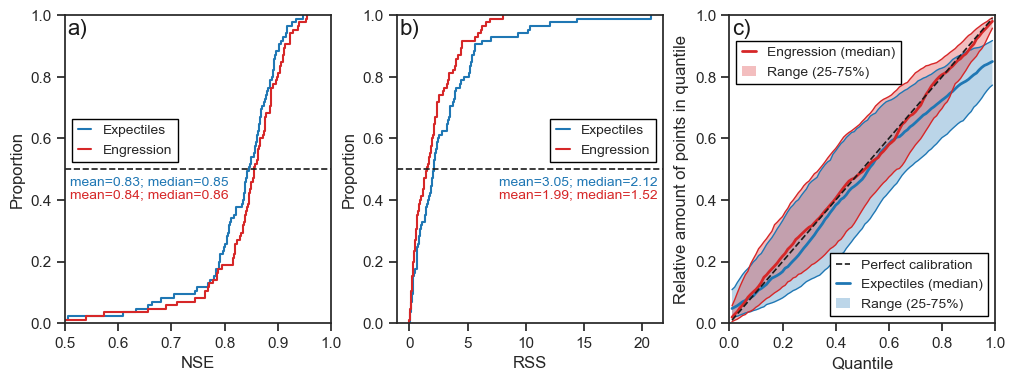

In [6]:

fig, axes = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'wspace': 0.25})

######## Plot NSE ########

ax = axes[0]

sns.ecdfplot(data=metric_exp_df, x='NSE', color='tab:blue', label='Expectiles', ax=ax)
sns.ecdfplot(data=metric_eng_df, x='NSE', color='tab:red', label='Engression', ax=ax)

ax.text(0.02, 0.48, f'mean={metric_exp_df.NSE.mean():0.2f}; median={metric_exp_df.NSE.median():0.2f}',
        transform=ax.transAxes, va='top', ha='left', color='tab:blue', fontsize=10)
ax.text(0.02, 0.48, f'\nmean={metric_eng_df.NSE.mean():0.2f}; median={metric_eng_df.NSE.median():0.2f}',
        transform=ax.transAxes, va='top', ha='left', color='tab:red', fontsize=10)

ax.axhline(0.5, color='k', ls='--', lw=1.2)

ax.set_xlim(0.5, 1)
ax.set_xlabel('NSE')
ax.set_ylabel('Proportion')

# Put legend top center:
ax.legend(loc='lower left', bbox_to_anchor=(0., 0.5), handlelength=1.0)

######## Plot RSS ########

ax = axes[1]

sns.ecdfplot(data=metric_exp_df, x='RSS', color='tab:blue', label='Expectiles', ax=ax)
sns.ecdfplot(data=metric_eng_df, x='RSS', color='tab:red', label='Engression', ax=ax)

ax.text(0.98, 0.48, f'mean={metric_exp_df.RSS.mean():0.2f}; median={metric_exp_df.RSS.median():0.2f}',
        transform=ax.transAxes, va='top', ha='right', color='tab:blue', fontsize=10)
ax.text(0.98, 0.48, f'\nmean={metric_eng_df.RSS.mean():0.2f}; median={metric_eng_df.RSS.median():0.2f}',
        transform=ax.transAxes, va='top', ha='right', color='tab:red', fontsize=10)

ax.axhline(0.5, color='k', ls='--', lw=1.2)

ax.set_xlabel('RSS')
ax.set_ylabel('Proportion')

# Put legend top center:
ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.5), handlelength=1.0)

######## Plot Calibration ########

ax = axes[2]

for i, (cdf, name_nice) in enumerate(zip([cdf_exp.cdf, cdf_eng.cdf], ['Expectiles', 'Engression'])):
    x = np.arange(start=0.01, stop=1.0, step=0.01)

    if i == 0:
        color = 'tab:blue'
        sns.lineplot(x=x, y=x, ax=ax, label=f'Perfect calibration', color='k', linestyle='--', lw=1.2, zorder=-5)
    else:
        color = 'tab:red'

    med = np.median(cdf, axis=0)
    low = np.quantile(cdf, 0.25, axis=0)
    high = np.quantile(cdf, 0.75, axis=0)

    sns.lineplot(x=x, y=med, ax=ax, label=f'{name_nice} (median)', color=color, zorder=-10, lw=2)
    sns.lineplot(x=x, y=low, ax=ax, color=color, zorder=-10, lw=1)
    sns.lineplot(x=x, y=high, ax=ax, color=color, zorder=-10, lw=1)

    ax.fill_between(
        x=x, y1=low, y2=high, ec='none', fc=color, alpha=0.3, zorder=-20, label=f'Range (25-75%)')

ax.set_rasterization_zorder(-5)
ax.set_xlabel('Quantile')
ax.set_ylabel('Relative amount of points in quantile')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

handles, labels = ax.get_legend_handles_labels()
legend0 = ax.legend(handles[3:], labels[3:],  loc='upper left', bbox_to_anchor=(0.0, 0.94), handlelength=1.0)
blend_legend_color_with_alpha(legend=legend0, indices=[1], alpha=0.3)
plt.gca().add_artist(legend0)
legend1 = ax.legend(handles[:3], labels[:3],  loc='lower right', bbox_to_anchor=(1.0, 0.0), handlelength=1.0)
blend_legend_color_with_alpha(legend=legend1, indices=[2], alpha=0.3)

# ax.add_artist(legend0)
# ax.add_artist(legend1)

for ax , label in zip(axes, ['a)', 'b)', 'c)']):
    ax.annotate(label, xy=(0.01, 0.99), xycoords='axes fraction', fontsize=16,
                ha='left', va='top', color='k')

fig.savefig(SAVE_DIR / 'calibration_plot.eps', dpi=300, bbox_inches='tight')